<a href="https://colab.research.google.com/github/dmml-heriot-watt/group-coursework-ha/blob/harry-branch/DM_CW_Spotify_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries

In [20]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=db0cfd1d95c34f423eeeb73c3d187be95cb5109c85d63d71993adc1c456892ee
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyod.models.ecod import ECOD

Importing the dataset

In [34]:
#df = pd.read_csv('IMDbGenres.csv')
#df = pd.read_csv('IMDbGenres-clean.csv')
df = pd.read_csv('Spotify-Clean1.csv', encoding = 'latin-1')
df = df.iloc[:, 3:]
#x = df.iloc[:, [5,11]].values

In [35]:
df.top_genre.unique()

array(['neo mellow', 'detroit hip hop', 'dance pop', 'pop',
       'canadian pop', 'hip pop', 'barbadian pop', 'atl hip hop',
       'australian pop', 'indie pop', 'art pop', 'colombian pop',
       'big room', 'british soul', 'chicago rap', 'acoustic pop',
       'permanent wave', 'boy band', 'baroque pop', 'celtic rock',
       'electro', 'complextro', 'canadian hip hop', 'candy pop',
       'alaska indie', 'folk-pop', 'metropopolis', 'house',
       'australian hip hop', 'electropop', 'australian dance',
       'hollywood', 'canadian contemporary r&b',
       'irish singer-songwriter', 'tropical house', 'belgian edm',
       'french indie pop', 'hip hop', 'danish pop', 'latin',
       'canadian latin', 'electronic trap', 'edm', 'electro house',
       'downtempo', 'brostep', 'contemporary country', 'moroccan pop',
       'escape room', 'alternative r&b'], dtype=object)

In [36]:
df.top_genre.value_counts()

dance pop                    327
pop                           60
canadian pop                  34
barbadian pop                 15
boy band                      15
electropop                    13
british soul                  11
big room                      10
canadian contemporary r&b      9
neo mellow                     9
art pop                        8
complextro                     6
hip pop                        6
australian dance               6
atl hip hop                    5
australian pop                 5
edm                            5
permanent wave                 4
latin                          4
hip hop                        4
colombian pop                  3
tropical house                 3
brostep                        2
downtempo                      2
electronic trap                2
belgian edm                    2
escape room                    2
folk-pop                       2
electro                        2
indie pop                      2
detroit hi

In [37]:
modified_df = df.drop(['year', 'title', 'pop'], axis = 1)

KeyError: ignored

In [26]:
#adds all instances of pop in the genre column into one shared genre
for i in modified_df.top_genre:
    if 'pop' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'pop')

    elif 'hip hop' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'hip hop')

    elif 'edm' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'edm')

    elif 'r&b' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'pop')

    elif 'latin' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'latin')

    elif 'room' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'room')

    elif 'electro' in i:
        modified_df.top_genre = modified_df.top_genre.replace(i, 'edm')

#replaces all instances of chicago rap with hip hop
modified_df.top_genre = modified_df.top_genre.replace('chicago rap', 'hip hop')

In [27]:
modified_df.top_genre.value_counts()

pop                        495
boy band                    15
hip hop                     15
room                        12
edm                         12
british soul                11
neo mellow                   9
complextro                   6
australian dance             6
latin                        5
permanent wave               4
tropical house               3
brostep                      2
downtempo                    2
alaska indie                 1
irish singer-songwriter      1
hollywood                    1
house                        1
celtic rock                  1
contemporary country         1
Name: top_genre, dtype: int64

Remove genre types that have less than 4 instances within the dataset

In [28]:
cull_df = modified_df
value_counts = cull_df.stack().value_counts()
culled = value_counts[value_counts <= 3].index
cull_df.replace(culled, 'other', inplace=True)
cull_df.top_genre.value_counts()

pop                 495
hip hop              15
boy band             15
other                13
room                 12
edm                  12
british soul         11
neo mellow            9
complextro            6
australian dance      6
latin                 5
permanent wave        4
Name: top_genre, dtype: int64

In [29]:
modified_df.top_genre = cull_df.top_genre
modified_df[['bpm', 'nrgy', 'dnce', 'decibel', 'live', 'val', 'dur', 'acous', 'spch', 'artist']] = df[['bpm', 'nrgy', 'dnce', 'decibel', 'live', 'val', 'dur', 'acous', 'spch', 'artist']]

In [30]:
switch_df = modified_df
switch_df.isnull().any()
switch_df = switch_df.drop_duplicates()
switch_df = switch_df.reset_index(drop=True)

In [31]:
switch_df.bpm = switch_df.bpm.replace(0, switch_df.bpm.mean())
switch_df.decibel = switch_df.decibel.replace(-60, switch_df.decibel.mean())

In [32]:
cull_df = pd.get_dummies(switch_df[['artist', 'top_genre']])
switch_df = switch_df.join(cull_df, how='left')
switch_df = switch_df.drop(columns = ['artist', 'top_genre'], axis=1)
switch_df.shape

(594, 206)

In [33]:
from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(df)
outliers = clf.predict(df)

df["outliers"] = outliers

# Data without outliers
data_no_outliers = df[df["outliers"] == 0]
data_no_outliers = data_no_outliers.drop(["outliers"], axis = 1)

# Data with Outliers
data_with_outliers = df.copy()
data_with_outliers = data_with_outliers.drop(["outliers"], axis = 1)

ValueError: ignored

Using the elbow method to find the optimal number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

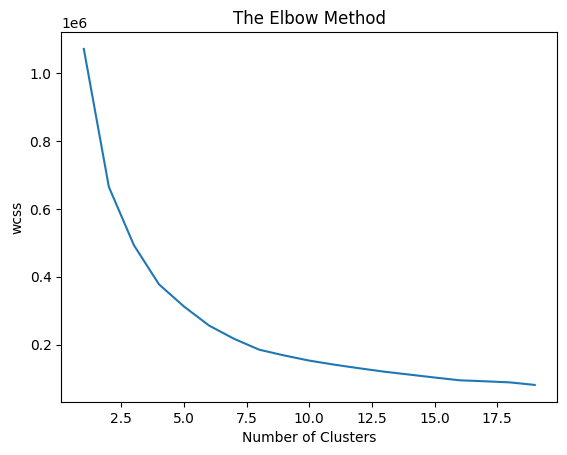

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
  kmeans = KMeans(n_clusters = i, init = 'k-means++') #, random_state = 42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

Using a dendrogram to find the optimal number of clusters

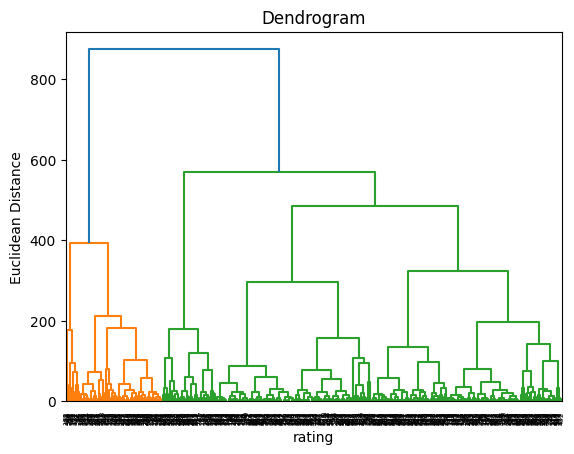

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('rating')
plt.ylabel('Euclidean Distance')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 12, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


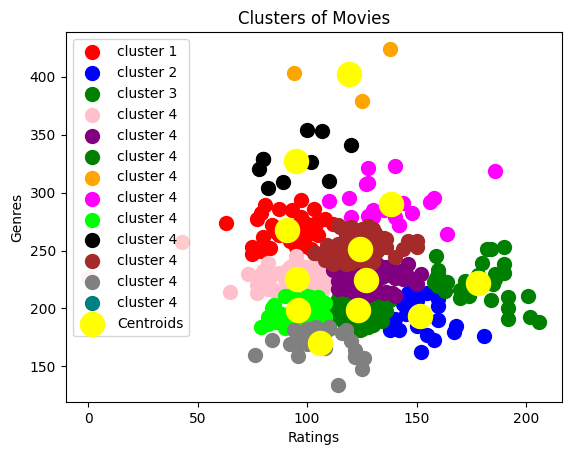

In [ ]:
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'red', label = 'cluster 1')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'cluster 2')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'cluster 3')
plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 100, c = 'pink', label = 'cluster 4')
plt.scatter(x[y_kmeans == 4, 0], x[y_kmeans == 4, 1], s = 100, c = 'purple', label = 'cluster 4')
plt.scatter(x[y_kmeans == 5, 0], x[y_kmeans == 5, 1], s = 100, c = 'green', label = 'cluster 4')
plt.scatter(x[y_kmeans == 6, 0], x[y_kmeans == 6, 1], s = 100, c = 'orange', label = 'cluster 4')
plt.scatter(x[y_kmeans == 7, 0], x[y_kmeans == 7, 1], s = 100, c = 'magenta', label = 'cluster 4')
plt.scatter(x[y_kmeans == 8, 0], x[y_kmeans == 8, 1], s = 100, c = 'lime', label = 'cluster 4')
plt.scatter(x[y_kmeans == 9, 0], x[y_kmeans == 9, 1], s = 100, c = 'black', label = 'cluster 4')
plt.scatter(x[y_kmeans == 10, 0], x[y_kmeans == 10, 1], s = 100, c = 'brown', label = 'cluster 4')
plt.scatter(x[y_kmeans == 11, 0], x[y_kmeans == 11, 1], s = 100, c = 'grey', label = 'cluster 4')
plt.scatter(x[y_kmeans == 12, 0], x[y_kmeans == 12, 1], s = 100, c = 'teal', label = 'cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Ratings')
plt.ylabel('Genres')
plt.legend()
plt.show()